## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
#from itertools import groupby

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Read train data

In [3]:
basedir = "../data/"
action_train = pd.read_csv(basedir + "trainingset/action_train.csv")
orderFuture_train = pd.read_csv(basedir + "trainingset/orderFuture_train.csv")
orderHistory_train = pd.read_csv(basedir + "trainingset/orderHistory_train.csv")
userComment_train = pd.read_csv(basedir + "trainingset/userComment_train.csv")
userProfile_train = pd.read_csv(basedir + "trainingset/userProfile_train.csv")
# origin_train_data = pd.read_csv(basedir + "origin_train_data.csv")
print action_train.shape
print pd.to_datetime(action_train['actionTime'].min(), unit='s')
print pd.to_datetime(action_train['actionTime'].max(), unit='s')

(1334856, 3)
2016-08-13 20:10:58
2017-09-10 23:57:45


## Read Test Data

In [4]:
action_test = pd.read_csv(basedir + "test/action_test.csv")
orderFuture_test = pd.read_csv(basedir + "test/orderFuture_test.csv")
orderHistory_test = pd.read_csv(basedir + "test/orderHistory_test.csv")
userComment_test = pd.read_csv(basedir + "test/userComment_test.csv")
userProfile_test = pd.read_csv(basedir + "test/userProfile_test.csv")
print action_test.shape
print pd.to_datetime(action_test['actionTime'].min(), unit='s')
print pd.to_datetime(action_test['actionTime'].max(), unit='s')

(331204, 3)
2016-09-14 16:45:04
2017-09-10 23:50:38


## Check missing

In [9]:
print userProfile_train.shape
print userProfile_train.apply(lambda x : sum(x.isnull()))

(40307, 4)
userid          0
gender      24547
province     3895
age         35565
dtype: int64


## Look at categories of all object variables:

In [3]:
var = ['gender', 'province', 'age']
for v in var:
    print '\nFrequency count for variable %s'%v
    print userProfile_train[v].value_counts()


Frequency count for variable gender
女    8620
男    7140
Name: gender, dtype: int64

Frequency count for variable province
上海     9760
北京     8301
广东     4784
江苏     2813
浙江     2447
四川     1310
湖北      741
辽宁      725
天津      722
福建      693
重庆      617
山东      510
湖南      334
陕西      323
广西      288
云南      242
黑龙江     234
河南      228
江西      214
安徽      206
河北      203
贵州      143
吉林      143
山西      108
内蒙古      79
新疆       69
甘肃       69
海南       61
宁夏       30
青海       11
西藏        4
Name: province, dtype: int64

Frequency count for variable age
80后    1667
70后    1308
60后    1061
90后     621
00后      85
Name: age, dtype: int64


In [10]:
var = ['orderType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print orderFuture_train[v].value_counts()

var = ['actionType']
for v in var:
    print '\nFrequency count for variable %s'%v
    print action_train[v].value_counts()

(20653, 10)
userid                int64
orderid               int64
orderTime             int64
orderType             int64
city                 object
country              object
continent            object
rating              float64
tags                 object
commentsKeyWords     object
dtype: object
         userid  orderid   orderTime  orderType city country continent  \
0  100000000013  1000015  1481714516          0   柏林      德国        欧洲   

   rating tags     commentsKeyWords  
0     4.0  NaN  ['很','简陋','太','随便']  


## Merge user Order History and comment

In [43]:
continent_gdp = pd.read_csv(basedir + "continent.csv")
def createFeature(dataset):
    orderHistory = pd.read_csv(basedir + "orderHistory_" + dataset + ".csv")
    userComment = pd.read_csv(basedir + "userComment_" + dataset + ".csv")
    orderFuture = pd.read_csv(basedir + "orderFuture_" + dataset + ".csv")
    userOrderHistoryComment = pd.merge(orderHistory, userComment, on=["userid", "orderid"], how='left')
    userOrderHistoryComment = pd.merge(userOrderHistoryComment, continent_gdp, on=["continent",], how='left')
    print userOrderHistoryComment.head(1)
    userOrderHistoryComment.drop('commentsKeyWords', axis=1, inplace=True)
    userOrderHistoryComment.drop('orderid', axis=1, inplace=True)
    
    userOrderHistoryComment_group = userOrderHistoryComment.groupby('userid')

    orderDf = pd.DataFrame(orderFuture['userid'], columns = ['userid'])


    orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].count(), on='userid')
    orderDf.rename(columns={'orderType': 'order_num'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].mean(), on='userid')
    orderDf.rename(columns={'rating': 'rating_mean'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].max(), on='userid')
    orderDf.rename(columns={'rating': 'rating_max'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].min(), on='userid')
    orderDf.rename(columns={'rating': 'rating_min'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['rating'].std(), on='userid')
    orderDf.rename(columns={'rating': 'rating_std'}, inplace=True)

    # Order Time
    orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].mean(), on='userid')
    orderDf.rename(columns={'orderTime': 'orderTime_mean'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].median(), on='userid')
    orderDf.rename(columns={'orderTime': 'orderTime_median'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].min(), on='userid')
    orderDf.rename(columns={'orderTime': 'orderTime_min'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].std(), on='userid')
    orderDf.rename(columns={'orderTime': 'orderTime_std'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].sum(), on='userid')
    orderDf.rename(columns={'orderType': 'orderType_sum'}, inplace=True)

    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].mean(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_mean'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].max(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_max'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].min(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_min'}, inplace=True)
    orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].std(), on='userid')
    orderDf.rename(columns={'continent_gdp': 'continent_gdp_std'}, inplace=True)

    order_month = pd.read_csv(basedir + "order_month_" + dataset + ".csv")
    orderDf = pd.merge(orderDf, order_month, on=["userid"], how='left')
    return orderDf


print createFeature("test").head(3)


         userid  orderid   orderTime  orderType city country continent  \
0  100000000371  1000029  1503443585          0   东京      日本        亚洲   

   rating tags commentsKeyWords  continent_gdp  
0     NaN  NaN              NaN          0.646  
         userid  order_num  rating_mean  rating_max  rating_min  rating_std  \
0  100000000371        1.0          NaN         NaN         NaN         NaN   
1  100000001215        NaN          NaN         NaN         NaN         NaN   
2  100000001445        5.0          5.0         5.0         5.0         NaN   

   orderTime_mean  orderTime_median  orderTime_min  orderTime_std  \
0    1.503444e+09      1.503444e+09   1.503444e+09            NaN   
1             NaN               NaN            NaN            NaN   
2    1.481080e+09      1.478532e+09   1.478514e+09   5.710714e+06   

       ...        order_month3  order_month4  order_month5  order_month6  \
0      ...                 0.0           0.0           0.0           0.0   
1      

In [5]:
userOrderHistoryComment_train = pd.merge(orderHistory_train, userComment_train, on=["userid", "orderid"], how='left')
# userOrderHistoryComment_train['orderTime'] = pd.to_datetime(action_train['orderTime'], unit = 's').dt.month
continent_gdp = pd.read_csv(basedir + "continent.csv")
userOrderHistoryComment_train = pd.merge(userOrderHistoryComment_train, continent_gdp, on=["continent",], how='left')
print userOrderHistoryComment_train.head(1)
userOrderHistoryComment_train.drop('commentsKeyWords', axis=1, inplace=True)
userOrderHistoryComment_train.drop('orderid', axis=1, inplace=True)
userOrderHistoryComment_group = userOrderHistoryComment_train.groupby('userid')

orderDf = pd.DataFrame(orderFuture_train['userid'], columns = ['userid'])


orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].count(), on='userid')
orderDf.rename(columns={'orderType': 'order_num'}, inplace=True)

orderDf = orderDf.join(userOrderHistoryComment_group['rating'].mean(), on='userid')
orderDf.rename(columns={'rating': 'rating_mean'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['rating'].max(), on='userid')
orderDf.rename(columns={'rating': 'rating_max'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['rating'].min(), on='userid')
orderDf.rename(columns={'rating': 'rating_min'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['rating'].std(), on='userid')
orderDf.rename(columns={'rating': 'rating_std'}, inplace=True)

# Order Time
orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].mean(), on='userid')
orderDf.rename(columns={'orderTime': 'orderTime_mean'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].median(), on='userid')
orderDf.rename(columns={'orderTime': 'orderTime_median'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].min(), on='userid')
orderDf.rename(columns={'orderTime': 'orderTime_min'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['orderTime'].std(), on='userid')
orderDf.rename(columns={'orderTime': 'orderTime_std'}, inplace=True)

orderDf = orderDf.join(userOrderHistoryComment_group['orderType'].sum(), on='userid')
orderDf.rename(columns={'orderType': 'orderType_sum'}, inplace=True)

orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].mean(), on='userid')
orderDf.rename(columns={'continent_gdp': 'continent_gdp_mean'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].max(), on='userid')
orderDf.rename(columns={'continent_gdp': 'continent_gdp_max'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].min(), on='userid')
orderDf.rename(columns={'continent_gdp': 'continent_gdp_min'}, inplace=True)
orderDf = orderDf.join(userOrderHistoryComment_group['continent_gdp'].std(), on='userid')
orderDf.rename(columns={'continent_gdp': 'continent_gdp_std'}, inplace=True)

order_month_train = pd.read_csv(basedir + "order_month_train.csv")
orderDf = pd.merge(orderDf, order_month_train, on=["userid"], how='left')
# orderDf = orderDf.join(userOrderHistoryComment_train.groupby('userid').sum(), on='userid')
# orderDf = pd.merge(orderFuture_train, userOrderHistoryComment_train.groupby('userid').mean(), on=['userid'], how='left')
#print userOrderHistoryComment_train.head(1)
print orderDf.head(3)

         userid  orderid   orderTime  orderType city country continent  \
0  100000000013  1000015  1481714516          0   柏林      德国        欧洲   

   rating tags     commentsKeyWords  continent_gdp  
0     4.0  NaN  ['很','简陋','太','随便']          2.634  
         userid  order_num  rating_mean  rating_max  rating_min  rating_std  \
0  100000000013        2.0          4.0         4.0         4.0         NaN   
1  100000000111        NaN          NaN         NaN         NaN         NaN   
2  100000000127        NaN          NaN         NaN         NaN         NaN   

   orderTime_mean  orderTime_median  orderTime_min  orderTime_std  \
0    1.491837e+09      1.491837e+09   1.481715e+09   1.431547e+07   
1             NaN               NaN            NaN            NaN   
2             NaN               NaN            NaN            NaN   

       ...        order_month3  order_month4  order_month5  order_month6  \
0      ...                 0.0           0.0           0.0           0.0   

In [46]:
city_data = pd.read_csv(basedir + "city_info.data", delimiter='\t', names = ['province', 'city_gdp', 'city_gdp1'])
city_data.drop('city_gdp1', axis=1, inplace=True)
def createUserProfileFeature(dataset):
    userProfile = pd.read_csv(basedir + "userProfile_" + dataset + ".csv")
    userProfile_deal = pd.merge(userProfile, city_data, on=['province'], how='left')
    userProfile_deal.drop('province', axis=1, inplace=True)
    print userProfile_deal.dtypes
    userProfile_deal['age'].fillna("null", inplace=True)

    def convertAge(x):
        if x == 'null':
            return 0
        x = str(x)
        num = int(x.split('后')[0])
        if(num == 0):
             return 18
        else:
            return 2018 - 1900 - num

    userProfile_deal['age'] = userProfile_deal['age'].apply(lambda x: convertAge(x))
    return userProfile_deal
print createUserProfileFeature("test").head(10)

userid        int64
gender       object
age          object
city_gdp    float64
dtype: object
         userid gender  age   city_gdp
0  100000000371    NaN    0  102919.55
1  100000001215    NaN    0        NaN
2  100000001445      男    0        NaN
3  100000001575      女    0        NaN
4  100000001601    NaN    0  102919.55
5  100000001737      男    0  102919.55
6  100000001829      男   58  106751.25
7  100000002055      男    0        NaN
8  100000002241    NaN    0  106751.25
9  100000003067    NaN    0  109032.71


In [6]:
# 城市GDP有好多城市不存在
city_data = pd.read_csv(basedir + "city_info.data", delimiter='\t', names = ['province', 'city_gdp', 'city_gdp1'])
city_data.drop('city_gdp1', axis=1, inplace=True)
userProfile_deal = pd.merge(userProfile_train, city_data, on=['province'], how='left')
# userProfile_deal.drop('city_gdp', axis=1, inplace=True)
# userProfile_deal.drop('gender', axis=1, inplace=True)
userProfile_deal.drop('province', axis=1, inplace=True)
print userProfile_deal.dtypes
userProfile_deal['age'].fillna("null", inplace=True)

def convertAge(x):
    if x == 'null':
        return 0
    x = str(x)
    num = int(x.split('后')[0])
    if(num == 0):
         return 18
    else:
        return 2018 - 1900 - num

userProfile_deal['age'] = userProfile_deal['age'].apply(lambda x: convertAge(x))

print userProfile_deal.head(10)

userid        int64
gender       object
age          object
city_gdp    float64
dtype: object
         userid gender  age   city_gdp
0  100000000013      男   58        NaN
1  100000000111    NaN    0  102919.55
2  100000000127    NaN    0  102919.55
3  100000000231      男   48  106751.25
4  100000000379      男    0  106751.25
5  100000000393      女    0  106751.25
6  100000000423    NaN    0        NaN
7  100000000459    NaN    0  106751.25
8  100000000465    NaN    0  106751.25
9  100000000471      女    0        NaN


In [50]:
def createActionTimeFeature(dataset):
    action_dataset = pd.read_csv(basedir + "action_" + dataset + ".csv")
    orderFuture = pd.read_csv(basedir + "orderFuture_" + dataset + ".csv")
    
    action_train_group = action_dataset.groupby('userid')
    actionDf = pd.DataFrame(orderFuture['userid'], columns = ['userid'])

    actionDf = actionDf.join(action_train_group['actionTime'].mean(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_mean'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].max(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_max'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].min(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_min'}, inplace=True)
    actionDf = actionDf.join(action_train_group['actionTime'].std(), on='userid')
    actionDf.rename(columns={'actionTime': 'actionTime_std'}, inplace=True)
    return actionDf

print createActionTimeFeature('train').head(3)

         userid  actionTime_mean  actionTime_max  actionTime_min  \
0  100000000013     1.487925e+09      1503238340      1474300753   
1  100000000111     1.490971e+09      1490971479      1490971433   
2  100000000127     1.492553e+09      1497815268      1490695669   

   actionTime_std  
0    8.187104e+06  
1    2.371357e+01  
2    2.994918e+06  


In [7]:
action_train_group = action_train.groupby('userid')
actionDf = pd.DataFrame(orderFuture_train['userid'], columns = ['userid'])

actionDf = actionDf.join(action_train_group['actionTime'].mean(), on='userid')
actionDf.rename(columns={'actionTime': 'actionTime_mean'}, inplace=True)
actionDf = actionDf.join(action_train_group['actionTime'].max(), on='userid')
actionDf.rename(columns={'actionTime': 'actionTime_max'}, inplace=True)
actionDf = actionDf.join(action_train_group['actionTime'].min(), on='userid')
actionDf.rename(columns={'actionTime': 'actionTime_min'}, inplace=True)
actionDf = actionDf.join(action_train_group['actionTime'].std(), on='userid')
actionDf.rename(columns={'actionTime': 'actionTime_std'}, inplace=True)

print actionDf.head(3)

         userid  actionTime_mean  actionTime_max  actionTime_min  \
0  100000000013     1.487925e+09      1503238340      1474300753   
1  100000000111     1.490971e+09      1490971479      1490971433   
2  100000000127     1.492553e+09      1497815268      1490695669   

   actionTime_std  
0    8.187104e+06  
1    2.371357e+01  
2    2.994918e+06  


In [8]:
action_train = action_train.sort_values(by='actionTime', ascending=True)
action_train_group = action_train.groupby("userid")
user_action_dict = dict(list(action_train_group))

In [30]:
print user_action_dict[111491416116]
print "---------"
count = 0
actionTimeIntevalResult = []
for userid, userid_action in user_action_dict.iteritems():
    userid = 111491416116
    userid_action = user_action_dict[111491416116]
    actionTimeIntevalResult.append(userid)
    actionTimeList = np.array(userid_action['actionTime'])
    actionTypeList = np.array(userid_action['actionType'])
    timeInterval = np.diff(actionTimeList)
    if len(timeInterval) == 0:
        # timeInterval = np.hstack(np.array([0] * (4 - len(timeInterval))), timeInterval)
        timeInterval = [0] * (4 - len(timeInterval)) + list(timeInterval)
        # timeInterval = np.array([0] * (4 - len(timeInterval))).hstack(timeInterval)
        timeInterval =  np.array(timeInterval)
    print timeInterval
    firstActionType = userid_action.head(1)['actionType']
    actionTimeIntevalResult = actionTimeIntevalResult + list(firstActionType)
    lastThreeActionType = userid_action.tail(3)['actionType']
    actionTimeIntevalResult = actionTimeIntevalResult + [0]*(3 - len(list(lastThreeActionType))) + list(lastThreeActionType)
    print actionTimeIntevalResult
    actionTimeIntevalResult = actionTimeIntevalResult + [timeInterval.mean(), timeInterval.std(), timeInterval.min()] + list(timeInterval[0:1]) + list(timeInterval[-4:])
    #print [timeInterval.mean(), timeInterval.std(), timeInterval.min(), timeInterval[0:1], timeInterval[-4:]] 
    print actionTimeIntevalResult
    actionTimeIntevalResult = actionTimeIntevalResult + [timeInterval[-3:].mean(), timeInterval[-3:].std()]
    # print [timeInterval[-3:].mean(), timeInterval[-3:].std()]
    print len(actionTimeIntevalResult)
    
    # 离最近的1-9的时间间隔统计
    IntevalDiff = []
    for i in range(2, 10):
        lastIndex = np.where(actionTypeList==i)
        if len(lastIndex[-1]) == 0:
            action29 = [0, 0, 0, 0]
        else:
            lastIndex = lastIndex[-1][-1]
            if len(timeInterval[lastIndex:]) == 0:
                action29 = [0, 0, 0, 0]
            else:
                action29 = [timeInterval[lastIndex:].min(), timeInterval[lastIndex:].mean(), timeInterval[lastIndex:].std(), timeInterval[lastIndex:].max()]
        IntevalDiff = IntevalDiff + action29
        print action29
    actionTimeIntevalResult = actionTimeIntevalResult + IntevalDiff
    print len(actionTimeIntevalResult)
    
    # 距离统计
    actionDis = []
    for i in range(2, 10):
        lastIndex = np.where(actionTypeList==i)
        if len(lastIndex[-1]) == 0:
            actionDistance = 0
        else:
            lastIndex = lastIndex[-1][-1]
            actionDistance = len(timeInterval[lastIndex:])
        actionDis =  actionDis + [actionDistance]
    actionTimeIntevalResult = actionTimeIntevalResult + actionDis
    print len(actionTimeIntevalResult)
    
    # 距离时间统计
    disTime = []
    for i in range(1, 10):
        lastIndex = np.where(actionTypeList==i)
        if len(lastIndex[-1]) == 0:
            actionTime = 0
        else:
            lastIndex = lastIndex[-1][-1]
            actionTime = timeInterval[lastIndex:].sum()
        disTime = disTime + [actionTime]
        print len(disTime)
    actionTimeIntevalResult = actionTimeIntevalResult + disTime
    print actionTimeIntevalResult
    print len(actionTimeIntevalResult)
    count = count + 1
    if count == 1:
        break
columns = ["userid", "firstAction", "last3Action", "last2Action", "last1Action", "intevalMean", "intevalStd", "intevalMin", "firstInteval", "lastInteval4", "lastInteval3", "lastInteval2", "lastInteval1", "last3IntevalMean", "last3IntevalStd"]
for i in range(2, 10):
    columns = columns + ["action" + str(i)+"min", "action" + str(i)+"mean", "action" + str(i)+"std", "action" + str(i)+"max"]
for i in range(2, 10):
    columns = columns + ["action" + str(i)+"Distance"]
for i in range(1, 10):
    columns = columns + ["action" + str(i)+"DistanceTime"]


              userid  actionType  actionTime
698597  111491416116           7  1495416093
---------
[0 0 0 0]
[111491416116, 7, 0, 0, 7]
[111491416116, 7, 0, 0, 7, 0.0, 0.0, 0, 0, 0, 0, 0, 0]
15
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0.0, 0.0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
47
55
1
2
3
4
5
6
7
8
9
[111491416116, 7, 0, 0, 7, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
64


In [56]:
def createTotalFeatures(dataset):
    action_type_rate = pd.read_csv(basedir + "action_rate_" + dataset + ".csv")
    user_month_action = pd.read_csv(basedir + "user_month_" + dataset + ".csv")
    orderDf = createFeature(dataset)
    actionDf = createActionTimeFeature(dataset)
    userProfile_deal = createUserProfileFeature(dataset)
    
    action_result = pd.merge(user_month_action, action_type_rate, on=["userid"], how='left')
    print action_result.shape
    train_data = pd.merge(orderDf, action_result, on=['userid'], how='left')
    train_data = pd.merge(train_data, actionDf, on=['userid'], how='left')
    train_data = pd.merge(userProfile_deal, train_data, on = ['userid'], how = 'left')
    if dataset == 'train':
        train_data = pd.merge(orderFuture_train, train_data, on=['userid'], how='left')
        train_data.rename(columns={'orderType': 'label'}, inplace=True)

    action_interval_train = pd.read_csv(basedir + "action_interval_"+ dataset + ".csv")
    train_data = pd.merge(train_data, action_interval_train, on=['userid'], how='left')


    # One-Hot Coding
    # data = pd.get_dummies(data, columns=var_to_encode)
    train_data = pd.get_dummies(train_data, columns=['gender'], dummy_na=True)
    return train_data

train_data =  createTotalFeatures('train')
test_data = createTotalFeatures('test')
print train_data.head(1)
print train_data.columns    

         userid  orderid   orderTime  orderType city country continent  \
0  100000000013  1000015  1481714516          0   柏林      德国        欧洲   

   rating tags     commentsKeyWords  continent_gdp  
0     4.0  NaN  ['很','简陋','太','随便']          2.634  
userid        int64
gender       object
age          object
city_gdp    float64
dtype: object
(40307, 31)
         userid  orderid   orderTime  orderType city country continent  \
0  100000000371  1000029  1503443585          0   东京      日本        亚洲   

   rating tags commentsKeyWords  continent_gdp  
0     NaN  NaN              NaN          0.646  
userid        int64
gender       object
age          object
city_gdp    float64
dtype: object
(10076, 31)
         userid  label  age  city_gdp  order_num  rating_mean  rating_max  \
0  100000000013      0   58       NaN        2.0          4.0         4.0   

   rating_min  rating_std  orderTime_mean     ...      action3DistanceTime  \
0         4.0         NaN    1.491837e+09     ...    

In [31]:
action_type_rate = pd.read_csv(basedir + "action_rate_train.csv")
#print action_type_rate.head(3)
user_month_action = pd.read_csv(basedir + "user_month_train.csv")
action_result = pd.merge(user_month_action, action_type_rate, on=["userid"], how='left')
print action_result.shape
train_data = pd.merge(orderDf, action_result, on=['userid'], how='left')
train_data = pd.merge(train_data, actionDf, on=['userid'], how='left')
train_data = pd.merge(userProfile_deal, train_data, on = ['userid'], how = 'left')
train_data = pd.merge(orderFuture_train, train_data, on=['userid'], how='left')
train_data.rename(columns={'orderType': 'label'}, inplace=True)

action_interval_train = pd.read_csv(basedir + "action_interval_train.csv")
train_data = pd.merge(train_data, action_interval_train, on=['userid'], how='left')


# One-Hot Coding
# data = pd.get_dummies(data, columns=var_to_encode)
train_data = pd.get_dummies(train_data, columns=['gender'], dummy_na=True)


print train_data.head(1)
print train_data.columns

(40307, 31)
         userid  label  age  city_gdp  order_num  rating_mean  rating_max  \
0  100000000013      0   58       NaN        2.0          4.0         4.0   

   rating_min  rating_std  orderTime_mean     ...      action3DistanceTime  \
0         4.0         NaN    1.491837e+09     ...                 978155.0   

   action4DistanceTime  action5DistanceTime  action6DistanceTime  \
0            7403238.0            1211361.0                  0.0   

   action7DistanceTime  action8DistanceTime  action9DistanceTime  gender_女  \
0            1278697.0            1278693.0            1278682.0         0   

   gender_男  gender_nan  
0         1           0  

[1 rows x 130 columns]
Index([u'userid', u'label', u'age', u'city_gdp', u'order_num', u'rating_mean',
       u'rating_max', u'rating_min', u'rating_std', u'orderTime_mean',
       ...
       u'action3DistanceTime', u'action4DistanceTime', u'action5DistanceTime',
       u'action6DistanceTime', u'action7DistanceTime', u'action8Di

In [57]:
target='label'
IDcol = 'userid'

In [58]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

337

Model Report
Accuracy : 0.9611
AUC Score (Train): 0.987716


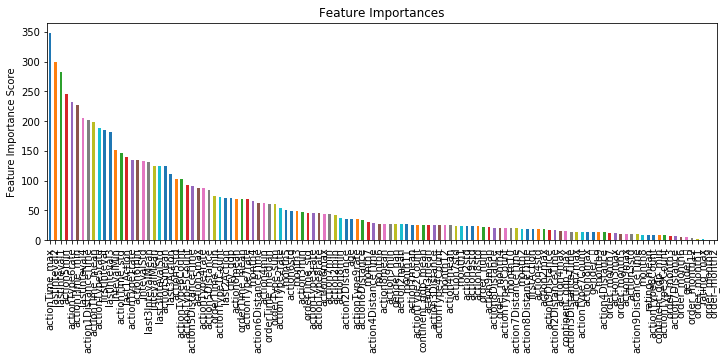

In [59]:
predictors = [x for x in train_data.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train_data, train_data, predictors)

In [60]:
prob = xgb1.predict_proba(test_data[predictors])[:,1]
submit = pd.read_csv(basedir + "test/orderFuture_test.csv")
submit['orderType'] = prob
print submit.to_csv(basedir + "submit_c.csv", index = False)

None


In [ ]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=181, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_data[predictors],train_data[target])